<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Caltech-256-128/resized/15*15/caltech256_15_15_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/caltech-256-image-aspect-preserved-128.zip -d caltech-256-image-aspect-preserved-128

In [ ]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 257
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
DATA_DIRECTORY = "caltech-256-image-aspect-preserved-128/caltech-256-image-aspect-preserved/"

In [ ]:
filenames = os.listdir(DATA_DIRECTORY)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

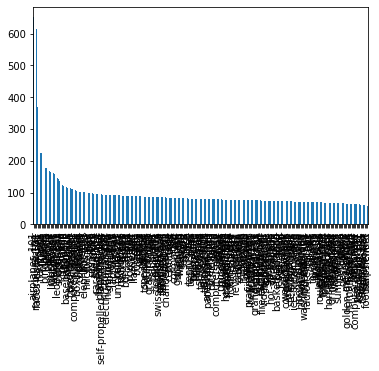

In [ ]:
train_df['category'].value_counts().plot.bar()

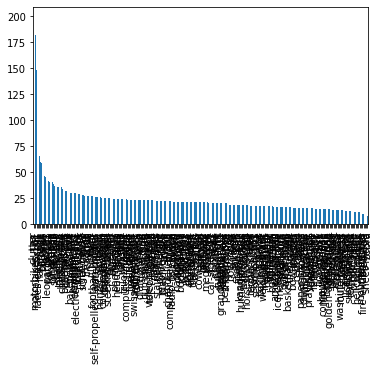

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 24485 validated image filenames belonging to 257 classes.


In [ ]:
validation_datagen = ImageDataGenerator(
    fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6122 validated image filenames belonging to 257 classes.


In [ ]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      21632     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_5 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 64)       

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 101s 130ms/step - loss: 5.3211 - accuracy: 0.0673 - auc: 0.6449 - val_loss: 6.0899 - val_accuracy: 0.0687 - val_auc: 0.6347
Epoch 2/1000
765/765 [==============================] - 100s 130ms/step - loss: 4.4784 - accuracy: 0.1359 - auc: 0.7714 - val_loss: 5.0108 - val_accuracy: 0.1068 - val_auc: 0.7086
Epoch 3/1000
765/765 [==============================] - 100s 130ms/step - loss: 4.1335 - accuracy: 0.1700 - auc: 0.8173 - val_loss: 4.0419 - val_accuracy: 0.1921 - val_auc: 0.8192
Epoch 4/1000
765/765 [==============================] - 100s 131ms/step - loss: 3.8790 - accuracy: 0.2027 - auc: 0.8418 - val_loss: 4.0292 - val_accuracy: 0.1998 - val_auc: 0.8195
Epoch 5/1000
765/765 [==============================] - 100s 130ms/step - loss: 3.6890 - accuracy: 0.2326 - auc: 0.8584 - val_loss: 3.5613 - val_accuracy: 0.2636 - val_auc: 0.8598
Epoch 6/1000
765/765 [==============================] - 100s 130ms/step - loss: 3.5463 - accuracy: 0

In [ ]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 18610.313057958
Finish time = 25468.752415599
Training time = 6858.439357641


In [ ]:
import pickle

trained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())
hist.history['untrained_layers'] = untrained_layers
hist.history['trained_layers'] = trained_layers

with open('caltech256-{}-history-kernel-{}.p'.format(ITERATION, GABOR_WIDTH),'wb') as fp:
    pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

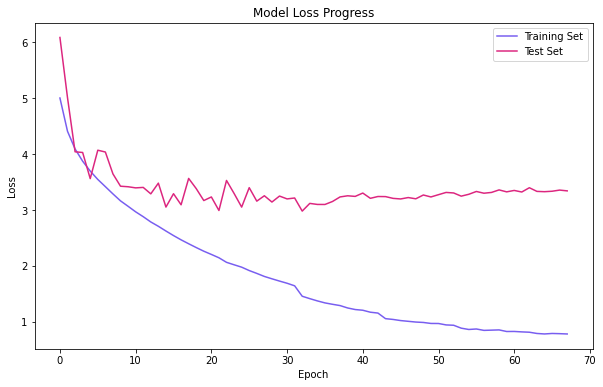

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

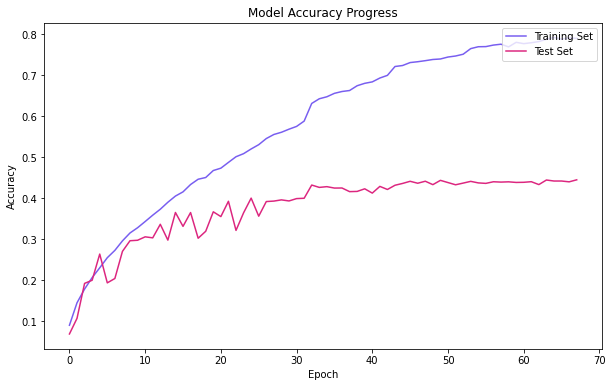

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

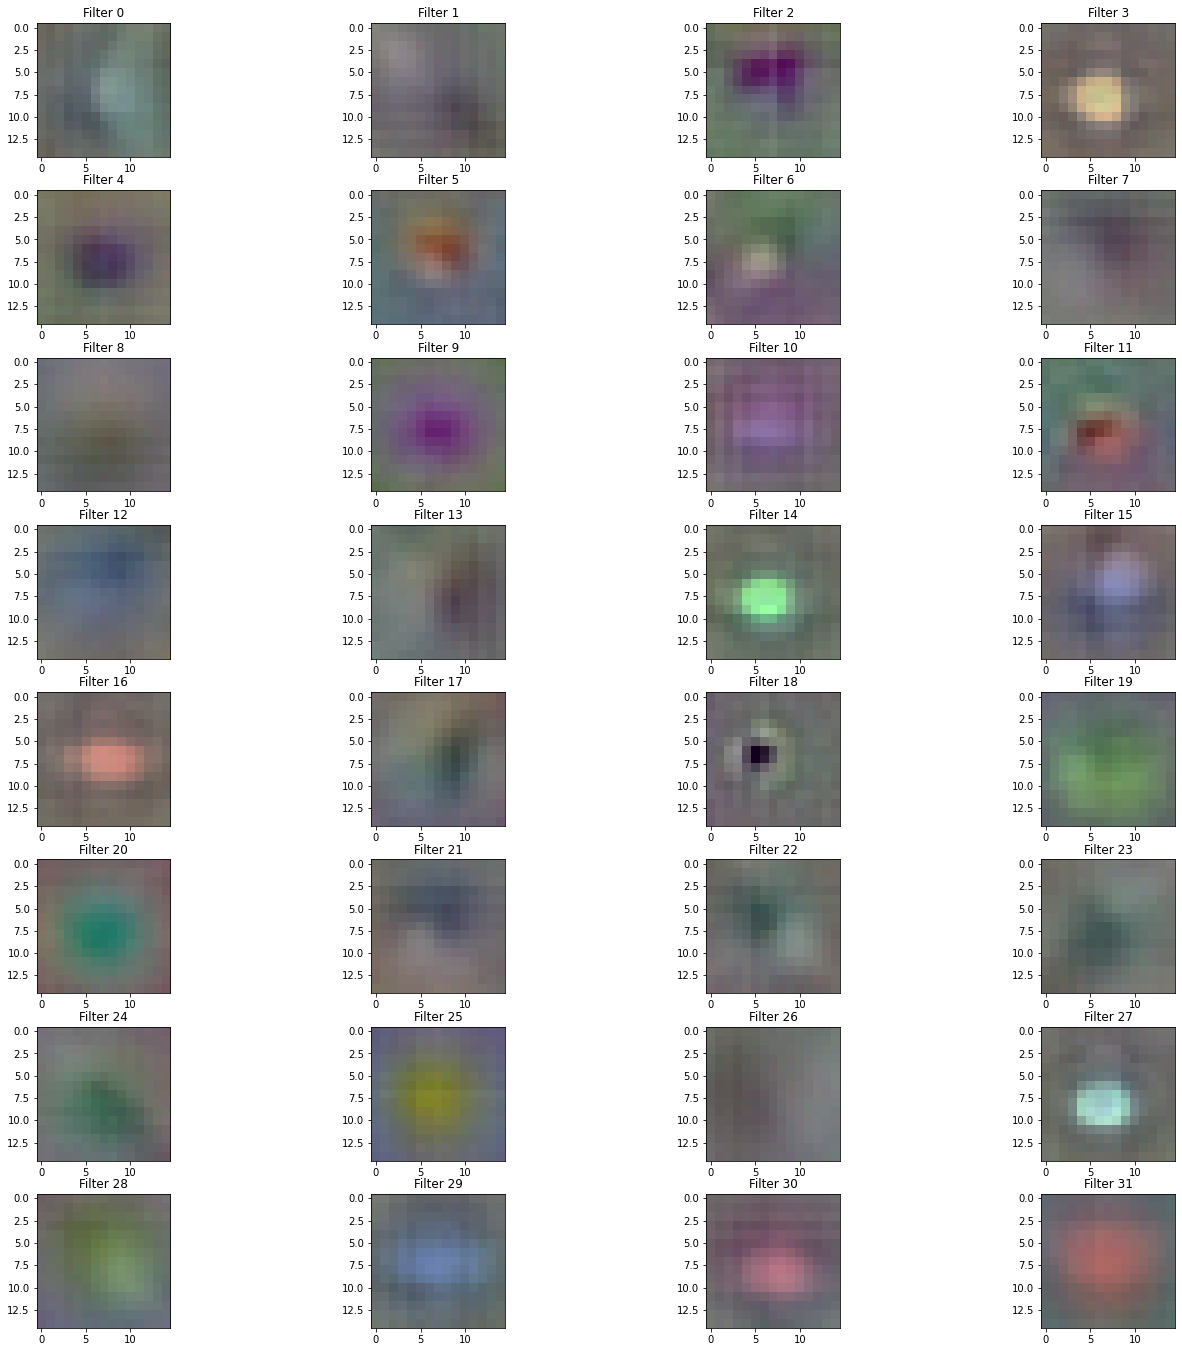

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("caltech256-{}-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

-1.1799543 1.6535987


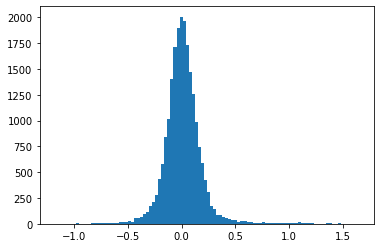

In [ ]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

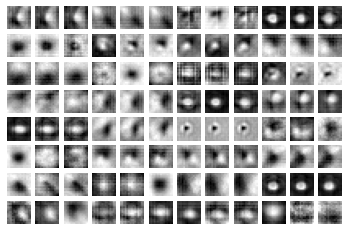

In [ ]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("caltech256-{}-channelwise-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [ ]:
!cp caltech256-1-history-kernel-15.p /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-loss-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-accuracy-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/

In [ ]:
!cp caltech256-1-channelwise-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech-256-aspect-preserved-new-config-128/1/